# CMB-S4 Instrumentation Summer School

## Holography Lab Notebook #1: Data Visualization
Authors: Grace E. Chesmore

In this notebook, we will:
1. Plot your team's beam data.
2. Compare your data to the expected beams.
3. Determine sources of noise in the measurement.

### Plotting your team's beams.

In [39]:
# %load_ext blackcellmagic
# %%black
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import funcs

team = input("Enter your team name:")  # Enter your team name

if os.path.isdir("Data/" + team):  # Check if the directory exists
    print("Welcome " + team + "!")  # Welcome the team
else:  # If the directory does not exist
    print("Team name not found. Check spelling or check Data folder.")

Enter your team name: turbo_pump


Welcome turbo_pump!


You've recorded Electric field $\vec{E}(\theta)$, where $\theta$ is the angles of the beam with respect to the rotation axis.  But our telescopes measure power, so we'll need to convert our data:

$$ P(\theta) = |\vec{E}(\theta)|^2$$

### 1) Exercise: Plot your data below:
Pick which frequency you'd like to plot by:
1. changing the `frequency` variable in `dataParams`, and 
2. specify the range of your beam `sweep_ang` in `dataParams`.

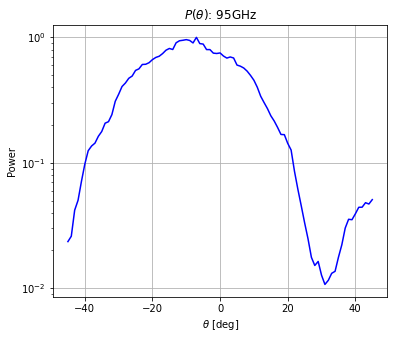

In [41]:
class dataParams:
    frequency = 95  # frequency of measurement [GHz]
    sweep_ang = 45  # sweep angle [deg]
    cut = "H"


angles, beam = funcs.getData1D(
    dataParams, team
)  # Get the data [theta,complex Electric field]

# Convert complex electric field to beam power
beam_power = abs(beam) ** 2  # <-- Your code here
beam_phase = np.arctan2(beam.imag, beam.real) * 180 / np.pi  # <-- Your code here

plt.figure(figsize=(6, 5))
plt.title(r"$P(\theta)$: " + str(dataParams.frequency) + "GHz")
plt.plot(angles, beam_power, color="b")  # <-- Change this line to plot your data
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel("Power")
plt.yscale("log")
plt.grid()

#### Lab questions:
1. Estimate the signal-to-noise of your beam.
2. What happens at the edges of the beam?
3. Plot the other frequencies that you've measured.  What do you notice between the different beam maps? (signal-to-noise, wide-angle shape, beam width, etc.)


### 2) Exercise: Compare your beam to a model.
We can determine properties of your measured beams by comparing them to a Gaussian:

$$ P(\theta) = \exp\left(-\frac{1}{2}\left(\frac{\theta-\theta_0}{\sigma}\right)^2\right)$$

Where $\theta_0$ is the center of the beam, and $\sigma$ is the width of the beam.  Change these two parameters (`sigma` and `x_0`) below to get the model to match your beam (as close as you can).

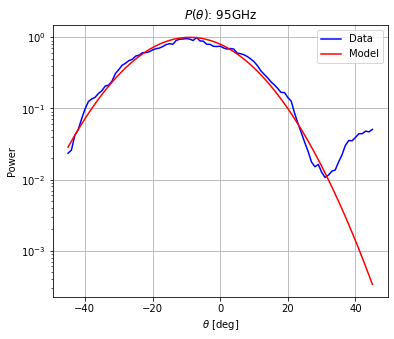

In [47]:
def gauss(x, mu, sigma):
    """
    Gaussian function
    """
    return np.exp(-((x - mu) ** 2) / (2 * sigma**2))


sigma = 13.5  # <-- Your code here
x_0 = -9  # <-- Your code here

model = gauss(angles, x_0, sigma)

plt.figure(figsize=(6, 5))
plt.title(r"$P(\theta)$: " + str(dataParams.frequency) + "GHz")
plt.plot(angles, beam_power, color="b", label="Data")
plt.plot(angles, model, color="r", label="Model")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel("Power")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

##### Lab questions:
1. From the model, what is the beam size, or [Full-width Half-maximum](https://en.wikipedia.org/wiki/Full_width_at_half_maximum)?
$$ FWHM =2\sqrt{2\ln{2}}\, \sigma$$
2. Where does the model fail to match your beam?

In [48]:
print(sigma * 2 * np.sqrt(2 * np.log(2)))  # <- Your code to calculate the FWHM here

31.790070607917816


### 3) Exercise: Feedhorn Cross-Talk

An important characterization of densely packed feedhorn arrays is "cross-talk", or how much power spills from one feedhorn to a neighboring feedhorn. Here you'll determine this by using your measured beam and seeing the field distribution on the face of the feedhorn aray.

In optics, we describe a wave as either being in the near-field or the far-field.  Conveniently, we can relate a far-field measurement to the near-field by a Fourier Transform:

$$U(x) = \int_{Aperature} B(\theta)e^{i\phi} d\theta$$ 

### Lab questions:
1. Was your beam map measured in the [near-field or the far-field](https://en.wikipedia.org/wiki/Near_and_far_field)?
(Hints: calculate $d_F$ and estimate how far away the source was from the feedhorn array, $d_M$, or distance of measurement.  If $d_M > d_F$ your measurement was in the far-field.)  Use the equation below for distance to the far-field regime:

$$ d_F = \frac{2D^2}{\lambda}$$

ANSWER: Far-field.

In [49]:
# Code to determine if in the near or far-field
lam = 0.002  # wavelength of your measurement [meters] <-- Your code here
D = 0.00515  # diameter of aperture (front opening of the feedhorn profile) [meters]
d_F = 2 * D**2 / lam  # distance to far-field regime [meters]
d_M = 1.0  # estimate how far the source horn was away from the feedhorn array [meters] <-- Your code here
print(r"$d_M$ = {}, $d_F$ = {}".format(d_M, d_F))

$d_M$ = 1.0, $d_F$ = 0.0265225


Now using the Fourier relationship above, convert your measurement (in the far-field) into the near-field (this is the electric field on the face of the feed-horn array).

The yellow boundary in the plot below shows the boundary of the feedhorn.  The blue line shows the electric field on the face of the feedhorn array.  Any signal outside of the boundary is "cross-talk", or power spilled from the main feedhorn and into neighboring feedhorns.  

2. What's the maximum cross-talk you're measuring from your plot? (Hint: use the `max()` function or look for the $2^{nd}$ highest peak in the plot).

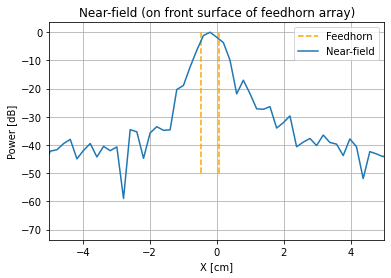

In [50]:
import scipy
from scipy import fft

# Fourier transform your data here
beam_temp = fft.fftshift(beam)  # Shift the data to the center
beam_temp = fft.fft(beam_temp)  # Fourier transform the data
beam_fft = fft.fftshift(beam_temp)  # Shift the data back to the original position

x_arr = funcs.coords_ang_to_spat(
    np.deg2rad(angles), dataParams.frequency
)  # convert angles to spatial coordinates
# Plot the near-field
plt.figure()
plt.title("Near-field (on front surface of feedhorn array)")
plt.ylabel("Power [dB]")
plt.xlabel("X [cm]")
plt.vlines(
    x_arr[np.where(abs(beam_fft) == np.max(abs(beam_fft)))] - (D * 1e2 / 2),
    -50,
    0,
    linestyle="--",
    color="orange",
    label="Feedhorn",
)
plt.vlines(
    x_arr[np.where(abs(beam_fft) == np.max(abs(beam_fft)))] + (D * 1e2 / 2),
    -50,
    0,
    linestyle="--",
    color="orange",
)
plt.plot(x_arr, 20 * np.log10(abs(beam_fft) / max(abs(beam_fft))), label="Near-field")
plt.xlim(-5, 5)
plt.legend()
plt.grid()
plt.show()